In [7]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib

import time
import cartopy.crs as ccrs
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.observationsAndERA5.mountainUtils import *; from tools.generalTools import *; from tools.BLtools import *
from tools.e5tools import e5_climatology
from orographicPrecipitation.observationsAndERA5.linear_precip_models_2D import *
xr.set_options(display_style='text') 

%load_ext autoreload
%autoreload 2

# Functions, data loading

In [2]:
#ERA5_MPATH4 = "/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.an.pl.monthly/"
#
#def monthlypaths():
#return xr.open_mfdatasetERA5_MPATH4 + "e5.oper.an.pl.%s.ll025sc.%s*.nc"%(varid,year)

In [16]:
%%time
#era5t_seasmean = e5_climatology('128_130_t',range(2010,2012))
#era5z_seasmean = e5_climatology('128_129_z',range(2010,2012))
#era5q_seasmean = e5_climatology('128_133_q',range(2010,2012))
#era5w_seasmean = e5_climatology('128_135_w',range(2010,2012))
era5t_seasmean = xr.open_zarr("/pscratch/sd/q/qnicolas/temp/climatology_era5_T.zarr").T.groupby("time.month").mean("time").compute()
era5z_seasmean = xr.open_zarr("/pscratch/sd/q/qnicolas/temp/climatology_era5_Z.zarr").Z.groupby("time.month").mean("time").compute()
era5q_seasmean = xr.open_zarr("/pscratch/sd/q/qnicolas/temp/climatology_era5_Q.zarr").Q.groupby("time.month").mean("time").compute()
era5w_seasmean = xr.open_zarr("/pscratch/sd/q/qnicolas/temp/climatology_era5_W.zarr").W.groupby("time.month").mean("time").compute()

CPU times: user 52.1 s, sys: 1min 54s, total: 2min 46s
Wall time: 24.5 s


In [17]:
Ghats      = MountainRangeCustom("ghats"      ,[64,82,7,24]   ,"Western Ghats"           ,70 ,[6,7,8]  ,[ 75  ,   9  ,  71.5, 20   ,2  ])
Myanmar    = MountainRangeCustom("myanmar"    ,[84,102,7,24]  ,"Myanmar"                 ,60 ,[6,7,8]  ,[ 98  ,  11  ,  90  , 21   ,4  ])
Vietnam    = MountainRangeCustom("vietnam"    ,[100,118,8,25] ,"Vietnam",240,[10,11]  ,[108  ,  18  , 111  , 13   ,2  ])
Malaysia   = MountainRangeCustom("malaysia"   ,[96,114,-2,15] ,"Malaysia"                ,225,[11,12]  ,[102.5,   8  , 105.5,  3   ,2  ])
Philippines= MountainRangeCustom("philippines",[117,135,5,22] ,"Philippines"             ,225,[11,12]  ,[123.5,  17  , 127  ,  9   ,2  ])
Newbritain = MountainRangeCustom("newbritain" ,[145,163,-17,0],"Papua New Guinea"             ,320,[6,7,8]  ,[154  , - 5.5, 150  , -8.5 ,2  ])

MRs = (Ghats,Myanmar,Vietnam,Malaysia,Philippines,Newbritain)

for MR in MRs:
    print(MR.name)
    MR.vars['T'] = sel_box_months(era5t_seasmean,MR.box,MR.months)
    MR.vars['Q'] = sel_box_months(era5q_seasmean,MR.box,MR.months)
    MR.vars['GZ'] = sel_box_months(era5z_seasmean,MR.box,MR.months)
    cp=1004;Lv=2.5e6;g=9.81
    MR.vars['MSE'] = cp*MR.vars['T'] + Lv*MR.vars['Q'] + MR.vars['GZ']
    MR.vars['DSE'] = cp*MR.vars['T'] + MR.vars['GZ']
    MR.vars['W'] = sel_box_months(era5w_seasmean,MR.box,MR.months)

ghats
myanmar
vietnam
malaysia
philippines
newbritain


In [18]:
for MR in MRs:
    MR.mask_usptream_era5 = tilted_rect_distance(MR.vars['T'],*MR.box_tilted[:-1],-2,-6)

In [19]:
for MR in MRs:
    for varname in 'T','Q','GZ','MSE','DSE','W':
        MR.vars[varname+'_UPSTREAM'] = spatial_mean(MR.vars[varname],box=None,mask=MR.mask_usptream_era5)

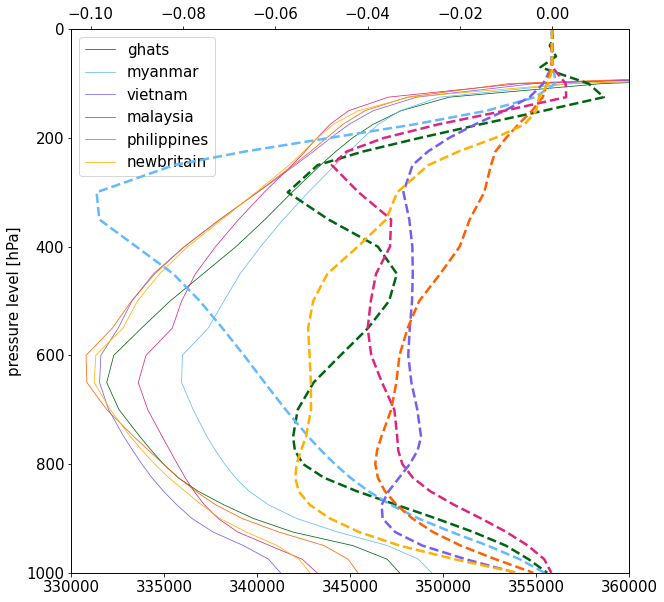

In [39]:
_,ax=plt.subplots(1,1,figsize=(10,10))
ax2=ax.twiny()
colors = ['#006511','#64B9FF','#785EF0','#DC267F','#FE6100','#FFB000']

for MR,clr in zip(MRs,colors):
    MR.vars['MSE_UPSTREAM'].plot(ax=ax,y='level',color=clr,linewidth=0.75,label=MR.name)
    MR.vars['W_UPSTREAM'].plot(ax=ax2,y='level',color=clr,linewidth=2.5,linestyle='--')
ax.set_xlim(330e3,360e3)
ax.set_ylim(1000,0)
ax.legend()

In [65]:
for MR in MRs:
    normalized_w =  MR.vars['W_UPSTREAM'].sel(level=slice(100,1000))/(MR.vars['W_UPSTREAM'].sel(level=slice(100,1000)).integrate('level')/900)
    GMS = -(MR.vars['MSE_UPSTREAM'].sel(level=slice(100,1000)).differentiate('level') * normalized_w).integrate('level')
    print("{:<11} : {:.2f} J/kg".format(MR.name,float(GMS)))

ghats       : 1235.27 J/kg
myanmar     : 8619.83 J/kg
vietnam     : 5653.09 J/kg
malaysia    : 8192.70 J/kg
philippines : -5946.35 J/kg
newbritain  : -534.57 J/kg


In [21]:
for MR in MRs:
    normalized_w =  MR.vars['W_UPSTREAM'].sel(level=slice(100,1000))/(MR.vars['W_UPSTREAM'].sel(level=slice(100,1000)).integrate('level')/900)
    GMS = -(MR.vars['MSE_UPSTREAM'].sel(level=slice(100,1000)).differentiate('level') * normalized_w).integrate('level')
    GDS = -(MR.vars['DSE_UPSTREAM'].sel(level=slice(100,1000)).differentiate('level') * normalized_w).integrate('level')
    print("{:<11} : {:.2f}".format(MR.name,float(GMS/GDS)))

ghats       : 0.03
myanmar     : 0.17
vietnam     : 0.11
malaysia    : 0.17
philippines : -0.12
newbritain  : -0.01


In [15]:
GMS/GDS

<xarray.DataArray (time: 24)>
dask.array<truediv, shape=(24,), dtype=float64, chunksize=(12,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2011-12-01

# Yu Et Al GMS

In [37]:
from scipy.integrate import cumtrapz

def qsat_WRF(t,p):
    eps=0.622
    s4=611.
    s5=5418.15
    es=s4*np.exp(s5*(1/273-1/t))
    return eps*(es/(p*100-es))

def A_npy(T,p):
    """T temperature in Kelvin, p in pascal. p must be increasing"""
    assert p[0]<p[1]
    L = 2.5e6
    Cp=1004.
    Rv = 461.
    gamma = L*qsat_WRF(T,p/100.)/Rv/T**2 * L/Cp
    kappa=2/7
    bl = np.where(p>95000.)[0]
    freetrop = np.where(p<=95000.)[0]
    integ = 1/(1+gamma[freetrop])*np.exp(kappa*cumtrapz(1/(1+gamma[freetrop][::-1]),np.log(p[freetrop][::-1]),initial=0))[::-1]
    a = np.concatenate([integ,integ[-1]*(p[bl]/p[freetrop][-1])**kappa])
    return  a

def Aplus_npy(T,p):
    idxs = np.where(~np.isnan(T))[0]
    n=len(p)
    T=T[idxs]
    p=p[idxs]
    a = A_npy(T,p)
    return np.concatenate([[np.nan]*idxs[0] ,-cumtrapz(a[::-1],np.log(p[::-1]),initial=0)[::-1],[np.nan]*(n-1-idxs[-1])])

def Aplus(T,p):
    return xr.apply_ufunc(Aplus_npy,T,p,input_core_dims=[['level'],['level']],output_core_dims=[['level']],vectorize=True)

def M(Z,q,T,p):
    Lv = 2.5e6
    Cp = 1004.
    g=9.81
    aplus = Aplus(T,p)
    Mq = - pressure_mean(aplus*Lv*q)       + pressure_mean(aplus)*pressure_mean(Lv*q)
    Ms =   pressure_mean(aplus*(Cp*T+g*Z)) - pressure_mean(aplus)*pressure_mean(Cp*T+g*Z)
    return Ms-Mq,Ms,Mq
def pressure_delta(column,pressure) :
    """given two arrays of the same length, return the pressure range corresponding to the non-nan values of column.
    e.g. if column = [nan,a,b,c,nan,nan] and pressure=[p1,p2,p3,p4,p5,p6], return p4-p2.
    Doesn't work if there are nans in the middle, eg. column = [nan,a,nan,c,nan,nan] (would still return p4-p2)"""
    
    idxs = np.where(~np.isnan(column))[0]
    try :
        return np.abs(pressure[idxs[-1]]-pressure[idxs[0]])
    except IndexError :
        print("Column only contains nans")
        return np.nan
def pressure_mean(da,vdim='level'):
    da_integ = da.fillna(0.).integrate(vdim)
    weights = xr.apply_ufunc(pressure_delta,da,da[vdim],input_core_dims=[[vdim],[vdim]],vectorize=True)#,dask="parallelized",output_dtypes=float)
    return da_integ/weights

In [48]:
# On our soundings. 
for MR in MRs:
    p_gms = MR.vars['T_UPSTREAM'] .sel(level=slice(100,1000)).level
    t_gms = MR.vars['T_UPSTREAM'] .sel(level=slice(100,1000))
    q_gms = MR.vars['Q_UPSTREAM'] .sel(level=slice(100,1000))
    z_gms = MR.vars['GZ_UPSTREAM'].sel(level=slice(100,1000))/9.81
    Mh,Ms,_=M(z_gms,q_gms,t_gms,p_gms*100)
    print("On WRF 3000-4900 upstream mean sounding : Mh,Ms,Mh/Ms = %i J/kg, %i J/kg, %.2f "%(Mh,Ms,Mh/Ms))


On WRF 3000-4900 upstream mean sounding : Mh,Ms,Mh/Ms = 1297 J/kg, 4586 J/kg, 0.28 
On WRF 3000-4900 upstream mean sounding : Mh,Ms,Mh/Ms = 919 J/kg, 4515 J/kg, 0.20 
On WRF 3000-4900 upstream mean sounding : Mh,Ms,Mh/Ms = 1386 J/kg, 4596 J/kg, 0.30 
On WRF 3000-4900 upstream mean sounding : Mh,Ms,Mh/Ms = 1041 J/kg, 4456 J/kg, 0.23 
On WRF 3000-4900 upstream mean sounding : Mh,Ms,Mh/Ms = 1149 J/kg, 4409 J/kg, 0.26 
On WRF 3000-4900 upstream mean sounding : Mh,Ms,Mh/Ms = 1254 J/kg, 4529 J/kg, 0.28 


# Theoretical model with negative GMS?

In [8]:
from orographicConvectionTheory.orographicConvectionTheory import topographic_profile, k_vector, m_exponent

In [9]:
def linear_precip_theory(xx,hx,U,NGMS=0.2,tauT=7.5,tauq=27.5,P0=4.,switch=1):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    Lv=2.5e6
    
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    
    tauT*=3600
    tauq*=3600
    
    Lq=U*0.6*tauq/NGMS
    
    ds0dz,dq0dz,N = lapse_rates()
    chi = pT_ov_g * (ds0dz/tauT - dq0dz/tauq)/ Lv * 86400
    
    zbot=1000
    ztop=3000    
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    Pprimehat = 1j*k/(1j*k + switch*1/Lq) * chi * np.fft.fft(hx) * np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1) 
    
    P = P0 + np.real(np.fft.ifft(Pprimehat))
    P = np.maximum(0.,P)
    return P

In [33]:
xx,hx = topographic_profile('cos')
#hx = 1000*np.exp(xx/1e5)/(1+np.exp(xx/1e5))
Pinf = linear_precip_theory(xx,hx,10,1e-5)
Pp2  = linear_precip_theory(xx,hx,10,0.2)
Pmp2 = linear_precip_theory(xx,hx,10,-0.2)

(-2000.0, 2000.0)

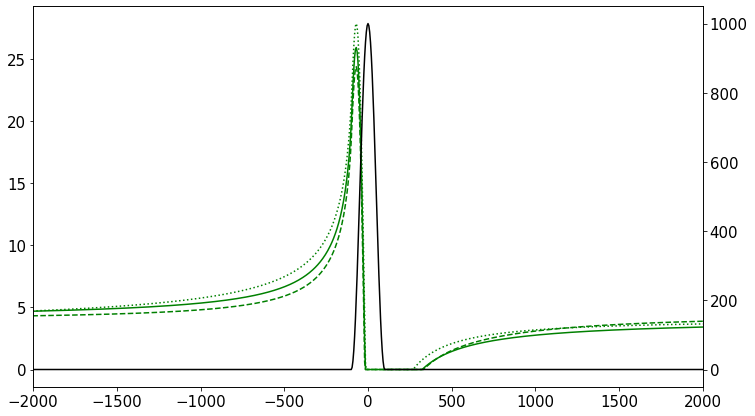

In [21]:
plt.figure(figsize=(12,7))
plt.plot(xx/1e3,Pinf,color='g',linestyle='-' ,label='NGMS=0')
plt.plot(xx/1e3,Pp2 ,color='g',linestyle='--',label='NGMS=0.2')
plt.plot(xx/1e3,Pmp2,color='g',linestyle=':' ,label='NGMS=-0.2')
plt.twinx()
plt.plot(xx/1e3,hx,color='k')
plt.xlim(-2000,2000)

In [10]:
import scipy.sparse as sps
import scipy.sparse.linalg as spsl

In [11]:
def linear_precip_theory_fd(xx,hx,U,NGMS=0.2,tauT=7.5,tauq=27.5,P0=4.,switch=1):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    Lv=2.5e6
    
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    
    tauT*=3600
    tauq*=3600
    
    Lq=U*0.6*tauq/NGMS
    
    ds0dz,dq0dz,N = lapse_rates()
    chi = pT_ov_g * (ds0dz/tauT - dq0dz/tauq)/ Lv * 86400
    
    zbot=1000
    ztop=3000    
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    forcing_hat = 1j*k * chi * np.fft.fft(hx) * np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1) 
    forcing =  np.real(np.fft.ifft(forcing_hat))
    
    n = len(xx)
    dx=xx[1]-xx[0]
    coef_implicit = 0.2
    Matrix = np.eye(n)/Lq + coef_implicit*(np.diag(1/dx*np.ones(n-1),1) - np.diag(1/dx*np.ones(n),0)) + (1-coef_implicit)*(np.diag(1/dx*np.ones(n),0) - np.diag(1/dx*np.ones(n-1),-1))
    Matrix[0,1]=0
    forcing[0] = 0
    Matrix[-1,-2] = -1/dx
    Matrix[-1,-1] = 1/dx +1/Lq
    Matrix = sps.csc_matrix(Matrix)
    Pprime = spsl.spsolve(Matrix,forcing)
    return np.maximum(0.,P0+Pprime)


In [23]:
xx,hx = topographic_profile('cos')
#hx = -1*(xx<0)*1000/np.minimum((xx/100e3-1),-1e-2)+(xx>=0)*1000/np.maximum((xx/100e3+1),1e-2)
#hx = 1000*np.exp(xx/1e5)/(1+np.exp(xx/1e5))

Pinf = linear_precip_theory(xx,hx,10,1e-5)
Pp2  = linear_precip_theory(xx,hx,10,0.2)
Pmp2 = linear_precip_theory(xx,hx,10,-0.3)

Pinf_fd = linear_precip_theory_fd(xx,hx,10,1e-5)
Pp2_fd  = linear_precip_theory_fd(xx,hx,10,0.2)
Pmp2_fd = linear_precip_theory_fd(xx,hx,10,-0.3)

(0.0, 1100.0)

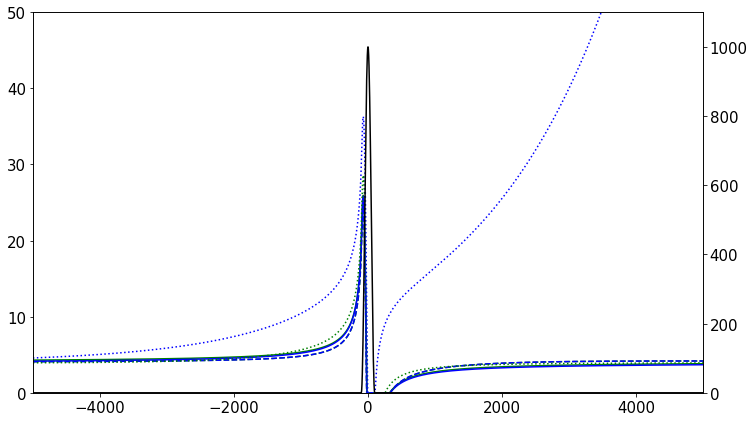

In [24]:
plt.figure(figsize=(12,7))
plt.plot(xx/1e3,Pinf,color='g',linestyle='-' ,label='NGMS=0')
plt.plot(xx/1e3,Pinf_fd,color='b',linestyle='-' ,label='NGMS=0')

plt.plot(xx/1e3,Pp2 ,color='g',linestyle='--',label='NGMS=0.2')
plt.plot(xx/1e3,Pp2_fd ,color='b',linestyle='--',label='NGMS=0.2')

plt.plot(xx/1e3,Pmp2,color='g',linestyle=':' ,label='NGMS=-0.2')
plt.plot(xx/1e3,Pmp2_fd,color='b',linestyle=':' ,label='NGMS=-0.2')
plt.ylim(0,50)
plt.twinx()
plt.plot(xx/1e3,hx,color='k')
plt.xlim(-5000,5000)
plt.ylim(0,1100)

In [32]:
import dask
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status"
from dask.distributed import Client
client=Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:43275 Dashboard: /user/qnicolas/perlmutter-shared-node-cpu/proxy/8787/status,Cluster Workers: 8 Cores: 256 Memory: 540.24 GB


In [50]:
# quick zarr test

test1 = xr.open_mfdataset('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.new.3km/wrfpout_d01_1971-*',combine='nested',concat_dim='Time',parallel=True)

In [28]:
%time test1.T.to_netcdf("/pscratch/sd/q/qnicolas/temp/testT.nc")

CPU times: user 965 ms, sys: 23.5 s, total: 24.4 s
Wall time: 25.6 s


In [34]:
%time test1.T.to_dataset(name='T').to_zarr("/pscratch/sd/q/qnicolas/temp/testT2.zarr")

CPU times: user 221 ms, sys: 59.7 ms, total: 281 ms
Wall time: 5.11 s


In [46]:
test1.T.chunks

((40, 40, 40, 40, 40, 40, 40, 40), (60,), (66,), (3270,))

In [52]:
%time test1.isel(Time=slice(0,240)).T_PL.chunk({'Time':24,'west_east':100}).to_dataset(name='T').to_zarr("/pscratch/sd/q/qnicolas/temp/testT4.zarr")

CPU times: user 890 ms, sys: 261 ms, total: 1.15 s
Wall time: 12.3 s


In [54]:
(34)*120*3

12240